In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
LAG = 48
EPS = 60
SIND = 30
HSIZE = 256
STOPS = 5
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
dset = SingleStop(
    SROUTE, SIND, 'train', 32, 
    lag=LAG, stops=STOPS).generator()
evalset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=LAG, stops=STOPS).generator(shuffle=False)

Locals dataset: train (metadata/8h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 9821
 [*] Subset train: 8020
 [*] Subset in Stop-30: 218
Locals dataset: test (metadata/8h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 9821
 [*] Subset test: 1801
 [*] Subset in Stop-30: 58


In [20]:
from models.temporal.RNN import *

In [21]:
if not DEEP:
    model = RNN_MIN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [22]:
criterion, opt, sch = model.params(lr=0.001)

In [23]:
# SOI (stop of interest) is the 0th stop
mseop = lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0])
evaluate(evalset, model, crit=lambda _y, y: np.sqrt(mseop(_y, y).item()))
evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item())

Eval loss: 3.0673 
Eval loss: 9.4081 


In [24]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item(), result=True))
    sys.stdout.flush()
#     sch.step()

[1/60 : 6/6] - L10.37      
Eval loss: 7.9697 
[2/60 : 6/6] - L7.75       
Eval loss: 7.0222 
[3/60 : 6/6] - L8.36      
Eval loss: 6.1503 
[4/60 : 6/6] - L6.32      
Eval loss: 5.3564 
[5/60 : 6/6] - L4.08      
Eval loss: 4.6558 
[6/60 : 6/6] - L4.54      
Eval loss: 4.0412 
[7/60 : 6/6] - L4.80      
Eval loss: 3.5570 
[8/60 : 6/6] - L3.62      
Eval loss: 3.1898 
[9/60 : 6/6] - L3.29      
Eval loss: 2.9104 
[10/60 : 6/6] - L2.81      
Eval loss: 2.7019 
[11/60 : 6/6] - L2.43      
Eval loss: 2.5499 
[12/60 : 6/6] - L2.96      
Eval loss: 2.4396 
[13/60 : 6/6] - L2.36      
Eval loss: 2.3618 
[14/60 : 6/6] - L3.09      
Eval loss: 2.3073 
[15/60 : 6/6] - L2.61      
Eval loss: 2.2689 
[16/60 : 6/6] - L2.30      
Eval loss: 2.2419 
[17/60 : 6/6] - L3.15      
Eval loss: 2.2232 
[18/60 : 6/6] - L2.91      
Eval loss: 2.2098 
[19/60 : 6/6] - L1.87      
Eval loss: 2.2002 
[20/60 : 6/6] - L1.73      
Eval loss: 2.1931 
[21/60 : 6/6] - L1.71      
Eval loss: 2.1876 
[22/60 : 6/6] - L1.7

In [25]:
VIEW_LAG=96
viewset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=5)
viewset = [viewset[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 59
 [*] Subset in Stop-30: 1


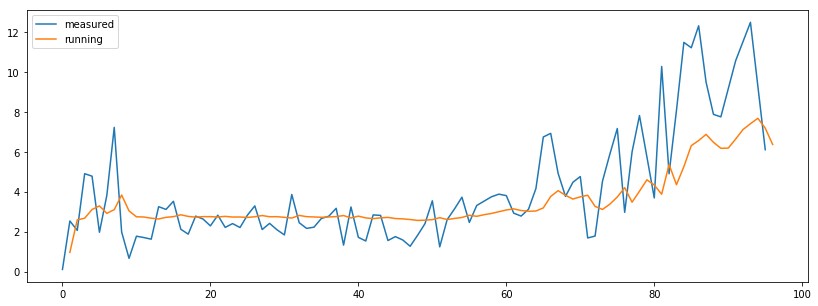

In [12]:
# STOPS = 1
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n1.pth')

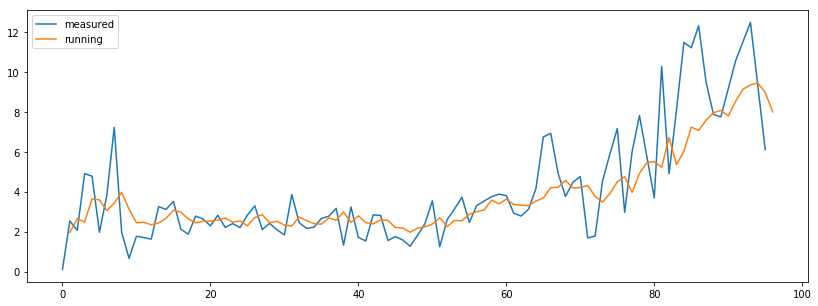

In [14]:
# STOPS = 5
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n5.pth')

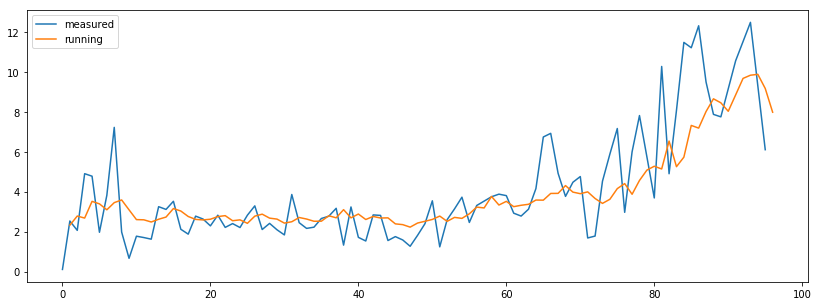

In [13]:
# DEEP = True
# STOPS = 5
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n5.pth')

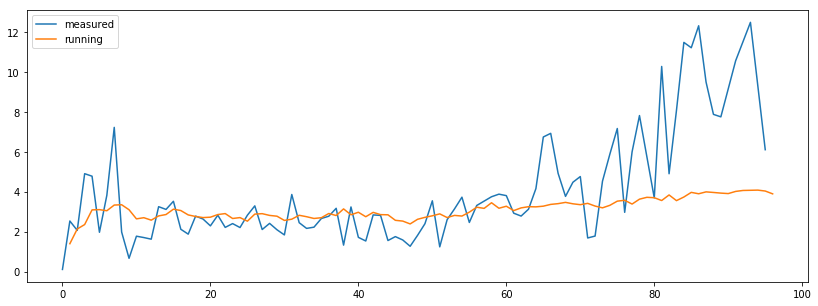

In [26]:
# DEEP = False
# STOPS = 5
# Lag = 48
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n5.pth')